In [23]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from collections import defaultdict
from jupyterthemes import jtplot
jtplot.style(theme="chesterish")

### Row data.csv

In [24]:
cd = os.getcwd()
data_row = pd.read_csv("{}/data.csv".format(cd))
data_row.head()

,subject_id,rt,stimulus,button_pressed,trial_type,trial_index,time_elapsed,internal_node_id,gender,age,...,status,nb_of_run,responses,question_order,stim_type,length,state_OR_event,branch_first,time_interval,node_selected
0,1,865.0,img/inst_1.png,0.0,image-button-response,0,872,0.0-0.0-0.0,female,31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,NaN,img/inst_2R.png,NaN,causal-graph1,1,2128,0.0-0.0-1.0,female,31,...,inactive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,NaN,"img/inst_3R.png,img/inst_3R.gif",NaN,causal-graph1,2,7684,0.0-0.0-2.0,female,31,...,inactive,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,NaN,img/inst_4R.png,NaN,causal-graph1,3,8299,0.0-0.0-3.0,female,31,...,inactive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,NaN,"img/inst_5R.png,img/inst_5RT.gif",NaN,causal-graph1,4,32664,0.0-0.0-4.0,female,31,...,inactive,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Demographical data only

In [3]:
data_demog = data_row[["subject_id","gender","age","language","country","turkcode"]]
data_demog.head()

,subject_id,gender,age,language,country,turkcode
0,1,female,31,German,Australia,R564181067660gxrw
1,1,female,31,German,Australia,R564181067660gxrw
2,1,female,31,German,Australia,R564181067660gxrw
3,1,female,31,German,Australia,R564181067660gxrw
4,1,female,31,German,Australia,R564181067660gxrw


### Target stimuli only (instructions deleted)

In [4]:
data = data_row[["subject_id","rt","stimulus","trial_type","sampling","status","nb_of_run","stim_type","length","state_OR_event",
                   "branch_first","time_interval","node_selected"]]
data = data[(data["trial_type"]=="causal-graph1") & (data["status"]=="active")].drop(["trial_type","status"],axis=1)
data.reset_index(drop=True,inplace=True)
stimulus = []
for items in data.stimulus.array:
    stimulus.append(items.split(",")[1].split("/")[1].split(".")[0])
stimulus = pd.Series(stimulus)
data.stimulus = stimulus
data.head()

,subject_id,rt,stimulus,sampling,nb_of_run,stim_type,length,state_OR_event,branch_first,time_interval,node_selected
0,1,19203.0,branch_RTSE2,Right,1.0,AND_Gate,Short,Event,Top,Medium,node12
1,1,9548.0,chain_RL,Right,2.0,Chain,Long,NaN,NaN,NaN,node3
2,1,7815.0,branch_RTSS,Right,1.0,AND_Gate,Short,State,Top,NaN,node7
3,1,12297.0,branch_RTLE1,Right,1.0,AND_Gate,Long,Event,Top,Short,node11
4,1,14463.0,branch_RTME3,Right,1.0,AND_Gate,Medium,Event,Top,Long,node4


### Chain only

In [5]:
data_chain = data[data["stim_type"]=="Chain"].drop(["stim_type","state_OR_event","branch_first","time_interval"],axis=1)
data_chain.reset_index(drop=True,inplace=True)
data_chain["stimulus"] = data_chain["stimulus"].astype("category")
data_chain["sampling"] = data_chain["sampling"].astype("category")
data_chain["length"] = data_chain["length"].astype("category")
data_chain.head()

,subject_id,rt,stimulus,sampling,nb_of_run,length,node_selected
0,1,9548.0,chain_RL,Right,2.0,Long,node3
1,1,8374.0,chain_RM,Right,1.0,Medium,node5
2,1,7238.0,chain_RS,Right,4.0,Short,node7
3,2,9484.0,chain_LM,Left,1.0,Medium,node8
4,2,7817.0,chain_LS,Left,1.0,Short,node7


### AND-Gate only

In [6]:
data_AND_Gate = data[data["stim_type"]=="AND_Gate"].drop(["stim_type"],axis=1)
data_AND_Gate.reset_index(drop=True,inplace=True)
data_AND_Gate["stimulus"] = data_AND_Gate["stimulus"].astype("category")
data_AND_Gate["state_OR_event"] = data_AND_Gate["state_OR_event"].astype("category")
data_AND_Gate["sampling"] = data_AND_Gate["sampling"].astype("category")
data_AND_Gate["length"] = data_AND_Gate["length"].astype("category")
data_AND_Gate["branch_first"] = data_AND_Gate["branch_first"].astype("category")
data_AND_Gate["time_interval"] = data_AND_Gate["time_interval"].astype("category")
data_AND_Gate.head()

,subject_id,rt,stimulus,sampling,nb_of_run,length,state_OR_event,branch_first,time_interval,node_selected
0,1,19203.0,branch_RTSE2,Right,1.0,Short,Event,Top,Medium,node12
1,1,7815.0,branch_RTSS,Right,1.0,Short,State,Top,NaN,node7
2,1,12297.0,branch_RTLE1,Right,1.0,Long,Event,Top,Short,node11
3,1,14463.0,branch_RTME3,Right,1.0,Medium,Event,Top,Long,node4
4,1,8475.0,branch_RTSE1,Right,1.0,Short,Event,Top,Short,node7


### General functions

In [84]:
class AndGate(object):

    def __init__(self,length=None):
        if length == "short":
            data = data_AND_Gate[data_AND_Gate["length"]=="Short"]
        elif length == "medium":
            data = data_AND_Gate[data_AND_Gate["length"]=="Medium"]
        elif length == "long":
            data = data_AND_Gate[data_AND_Gate["length"]=="Long"]
        self.df = data
        self.node_select = self.df["node_selected"].value_counts(normalize=True)*100
        values = {}
        nodes = ["node"+str(i+1) for i in range(15)]
        for item in nodes:
            if item not in self.node_select.keys():
                values[item] = 0
            else:
                values[item] = self.node_select[item]
        self.node_select = pd.Series(values)
        
    def add_filter(self,sampling=None,level=None,delay=None):
        if sampling == "right":
            self.df = self.df[self.df["sampling"]=="Right"]
        elif sampling == "left":
            self.df = self.df[self.df["sampling"]=="Left"]
        if level == "top":
            self.df = self.df[self.df["branch_first"]=="Top"]
        elif level == "bottom":
            self.df = self.df[self.df["branch_first"]=="Bottom"]
        if delay == "short":
            self.df = self.df[self.df["time_interval"]=="Short"]
        elif delay == "medium":
            self.df = self.df[self.df["time_interval"]=="Medium"]
        elif delay == "long":
            self.df = self.df[self.df["time_interval"]=="Long"]
        elif delay == False:
            self.df = self.df[self.df["state_OR_event"]=="State"]
        
        self.node_select = self.df["node_selected"].value_counts(normalize=True)*100
        values = {}
        nodes = ["node"+str(i+1) for i in range(15)]
        for item in nodes:
            if item not in self.node_select.keys():
                values[item] = 0
            else:
                values[item] = self.node_select[item]
        self.node_select = pd.Series(values)
        return self
    
class Chain(object):
    def __init__(self,length=None):
        if length == "short":
            data = data_chain[data_chain["length"]=="Short"]
        elif length == "medium":
            data = data_chain[data_chain["length"]=="Medium"]
        elif length == "long":
            data = data_chain[data_chain["length"]=="Long"]
        self.df = data
        self.node_select = self.df["node_selected"].value_counts(normalize=True)*100
        values = {}
        nodes = ["node"+str(i+1) for i in range(8)]
        for item in nodes:
            if item not in self.node_select.keys():
                values[item] = 0
            else:
                values[item] = self.node_select[item]
        self.node_select = pd.Series(values)
        
    def add_filter(self,sampling=None):
        if sampling == "right":
            self.df = self.df[self.df["sampling"]=="Right"]
        elif sampling == "left":
            self.df = self.df[self.df["sampling"]=="Left"]
        self.node_select = self.df["node_selected"].value_counts(normalize=True)*100
        values = {}
        nodes = ["node"+str(i+1) for i in range(8)]
        for item in nodes:
            if item not in self.node_select.keys():
                values[item] = 0
            else:
                values[item] = self.node_select[item]
        self.node_select = pd.Series(values)
        return self
    
def graph(list_of_data,title):
    fig = plt.figure(figsize=(6.6*len(list_of_data),5))
    a = str(len(list_of_data))
    for i,x in enumerate(list_of_data):
        axis = fig.add_subplot(int("1"+a+str(i+1)))
        axis.set_ylim([0,110])
        axis.set_xlabel("Detectors",labelpad=20)
        axis.set_ylabel("Percentage of responses")
        axis.label_outer()
        axis.spines["top"].set_visible(False)
        axis.spines["right"].set_visible(False)
        axis.set_title(title[i])
        x.node_select.plot.bar(ax=axis)

### Comparison Right *vs* Left

In [90]:
ChainShort = Chain("short")
ChainShort.gif

node1      0.0
node2      0.0
node3      0.0
node4      0.0
node5      0.0
node6      0.0
node7    100.0
node8      0.0
dtype: float64

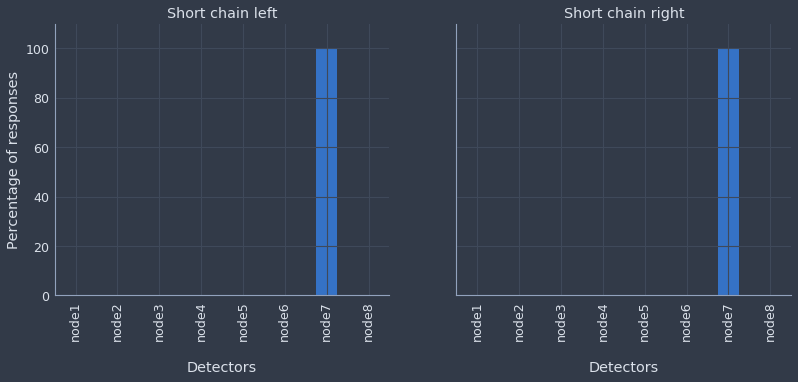

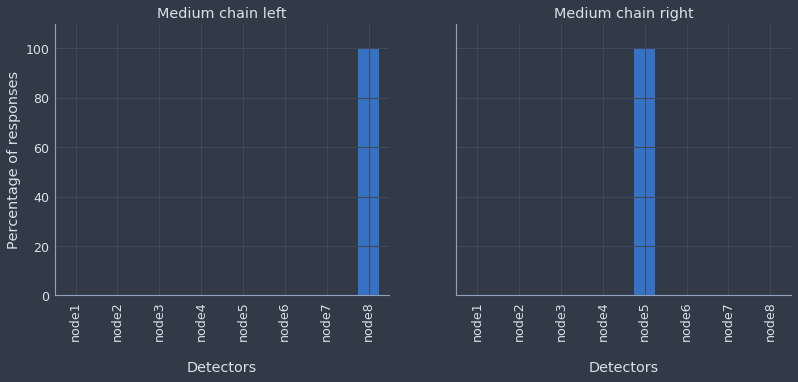

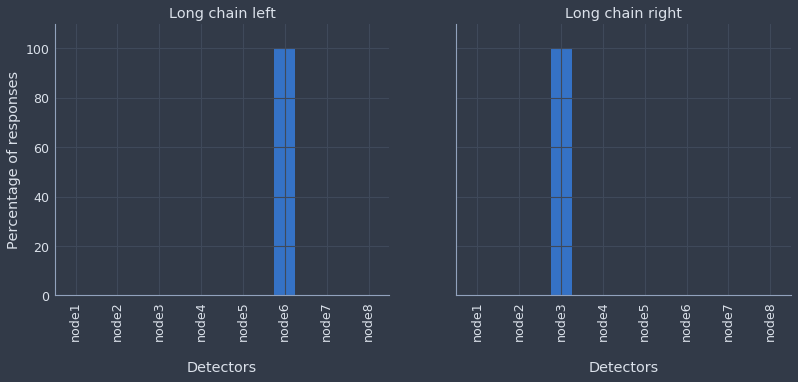

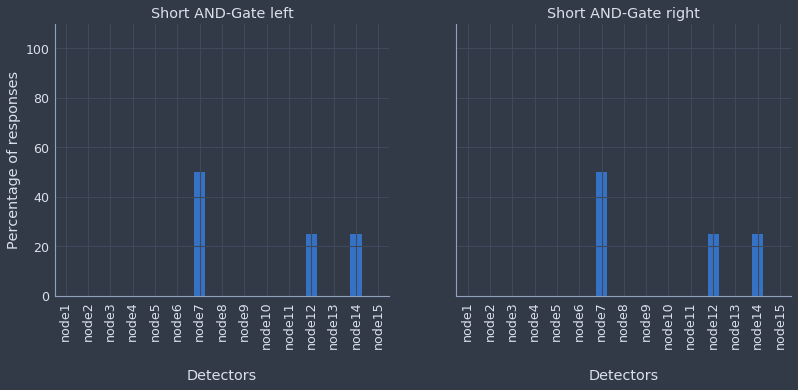

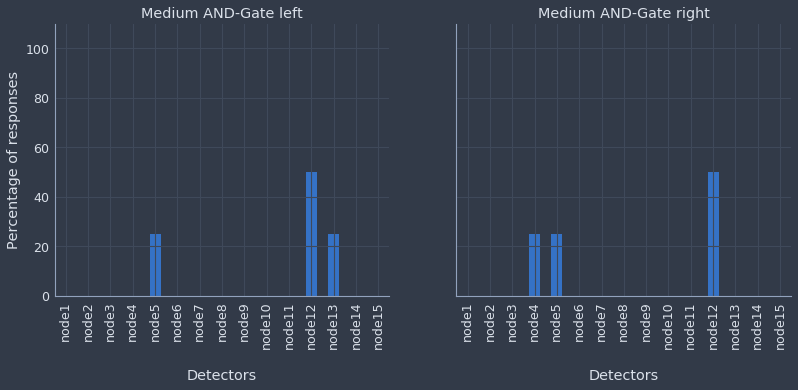

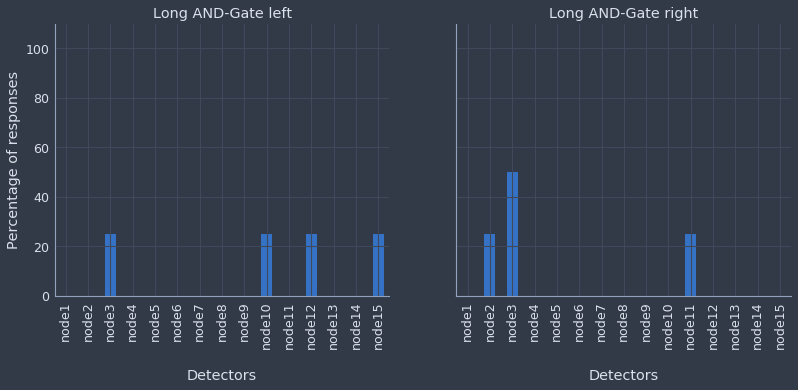

In [86]:
ChainShort_R = Chain("short").add_filter(sampling="right")
ChainMedium_R = Chain("medium").add_filter(sampling="right")
ChainLong_R = Chain("long").add_filter(sampling="right")
ChainShort_L = Chain("short").add_filter(sampling="left")
ChainMedium_L = Chain("medium").add_filter(sampling="left")
ChainLong_L = Chain("long").add_filter(sampling="left")
BranchShort_R = AndGate("short").add_filter(sampling="right")
BranchMedium_R = AndGate("medium").add_filter(sampling="right")
BranchLong_R = AndGate("long").add_filter(sampling="right")
BranchShort_L = AndGate("short").add_filter(sampling="left")
BranchMedium_L = AndGate("medium").add_filter(sampling="left")
BranchLong_L = AndGate("long").add_filter(sampling="left")

graph([ChainShort_L,ChainShort_R],["Short chain left","Short chain right"])
graph([ChainMedium_L,ChainMedium_R],["Medium chain left","Medium chain right"])
graph([ChainLong_L,ChainLong_R],["Long chain left","Long chain right"])
graph([BranchShort_L,BranchShort_R],["Short AND-Gate left","Short AND-Gate right"])
graph([BranchMedium_L,BranchMedium_R],["Medium AND-Gate left","Medium AND-Gate right"])
graph([BranchLong_L,BranchLong_R],["Long AND-Gate left","Long AND-Gate right"])

### Comparison Top *vs* Bottom

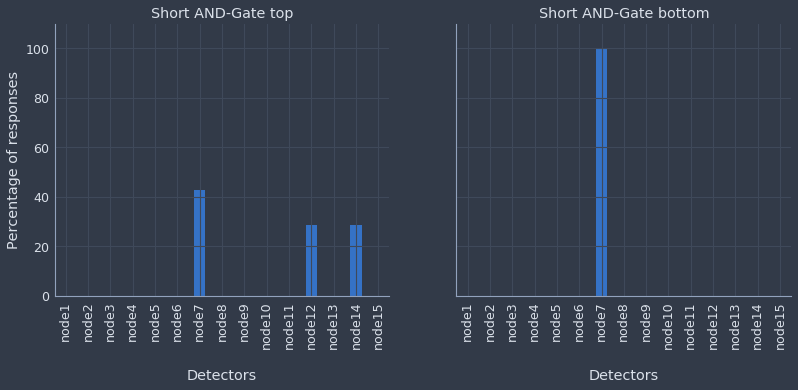

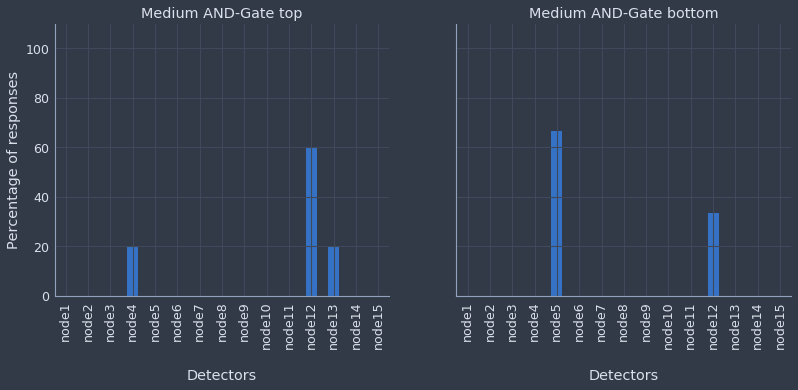

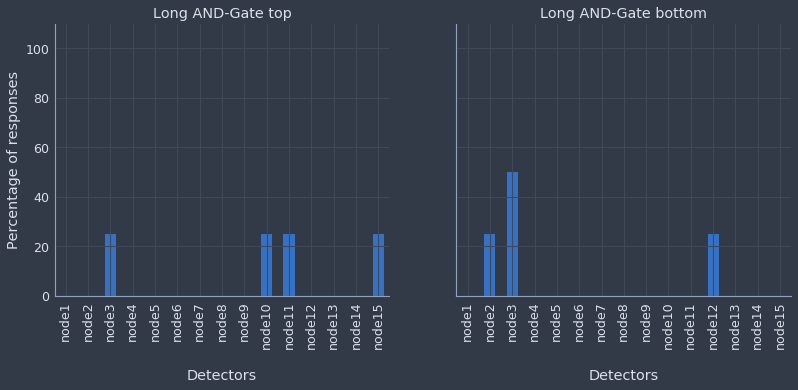

In [87]:
BranchShort_T = AndGate("short").add_filter(level="top")
BranchMedium_T = AndGate("medium").add_filter(level="top")
BranchLong_T = AndGate("long").add_filter(level="top")
BranchShort_B = AndGate("short").add_filter(level="bottom")
BranchMedium_B = AndGate("medium").add_filter(level="bottom")
BranchLong_B = AndGate("long").add_filter(level="bottom")

graph([BranchShort_T,BranchShort_B],["Short AND-Gate top","Short AND-Gate bottom"])
graph([BranchMedium_T,BranchMedium_B],["Medium AND-Gate top","Medium AND-Gate bottom"])
graph([BranchLong_T,BranchLong_B],["Long AND-Gate top","Long AND-Gate bottom"])

### General comparison

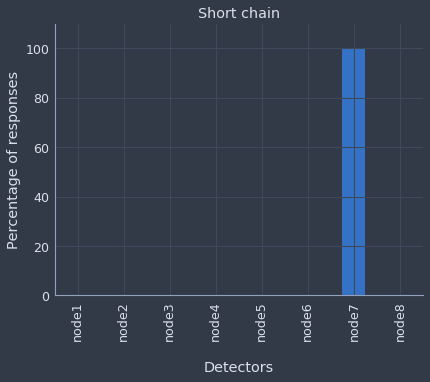

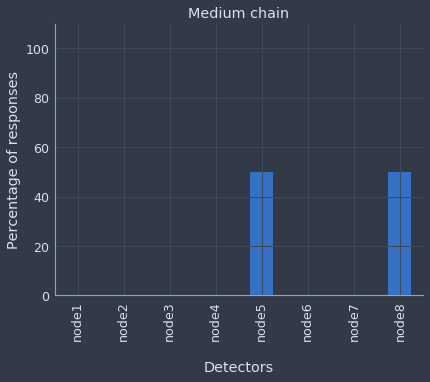

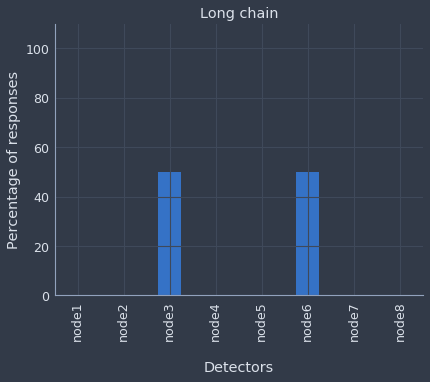

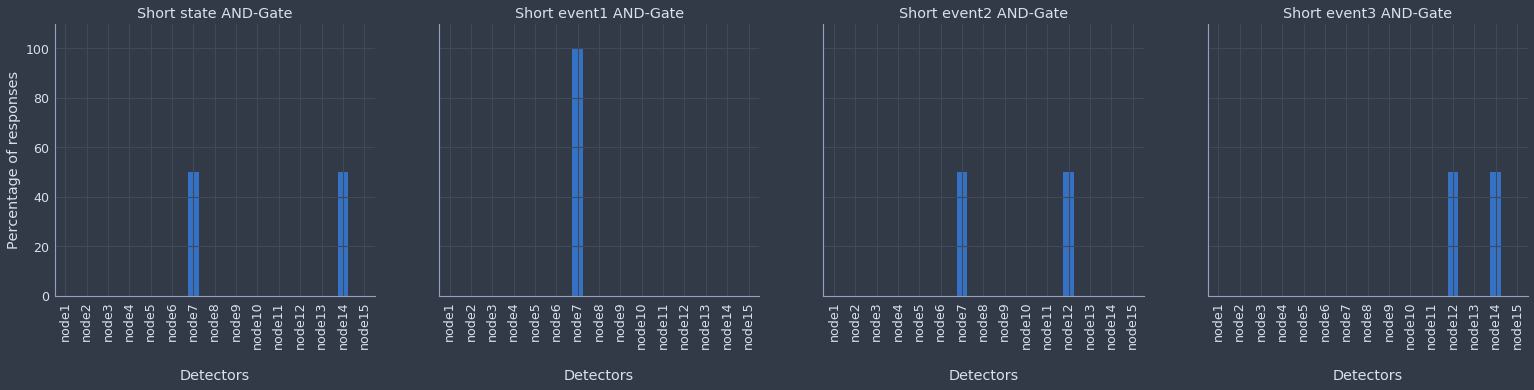

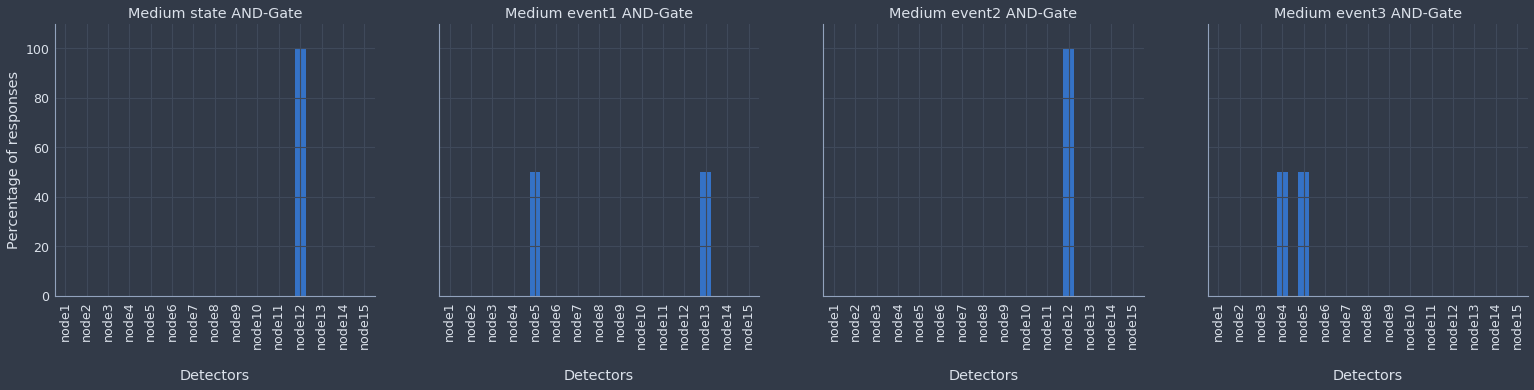

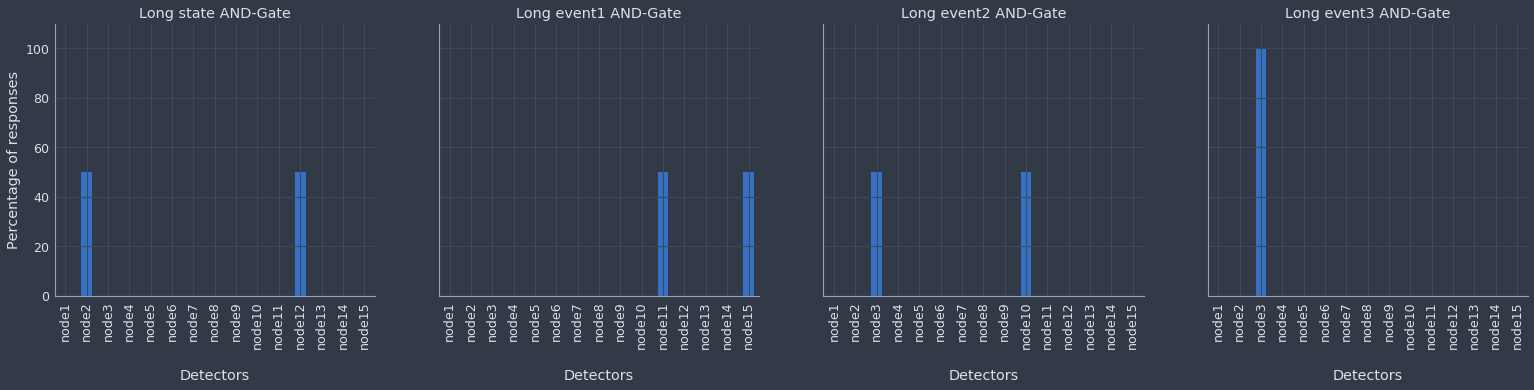

In [88]:
ChainShort = Chain("short")
ChainMedium = Chain("medium")
ChainLong = Chain("long")
ShortState = AndGate("short").add_filter(delay=False)
MediumState = AndGate("medium").add_filter(delay=False)
LongState = AndGate("long").add_filter(delay=False)
ShortEvent1 = AndGate("short").add_filter(delay="short")
ShortEvent2 = AndGate("short").add_filter(delay="medium")
ShortEvent3 = AndGate("short").add_filter(delay="long")
MediumEvent1 = AndGate("medium").add_filter(delay="short")
MediumEvent2  = AndGate("medium").add_filter(delay="medium")
MediumEvent3 = AndGate("medium").add_filter(delay="long")
LongEvent1 = AndGate("long").add_filter(delay="short")
LongEvent2  = AndGate("long").add_filter(delay="medium")
LongEvent3 = AndGate("long").add_filter(delay="long")

graph([ChainShort],["Short chain"])
graph([ChainMedium],["Medium chain"])
graph([ChainLong],["Long chain"])
graph([ShortState,ShortEvent1,ShortEvent2,ShortEvent3],["Short state AND-Gate","Short event1 AND-Gate",
                                                        "Short event2 AND-Gate","Short event3 AND-Gate"])
graph([MediumState,MediumEvent1,MediumEvent2,MediumEvent3],["Medium state AND-Gate","Medium event1 AND-Gate",
                                                        "Medium event2 AND-Gate","Medium event3 AND-Gate"])
graph([LongState,LongEvent1,LongEvent2,LongEvent3],["Long state AND-Gate","Long event1 AND-Gate",
                                                        "Long event2 AND-Gate","Long event3 AND-Gate"])